In [3]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow
import cv2
from datetime import datetime
from PIL import Image
from scipy import signal

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


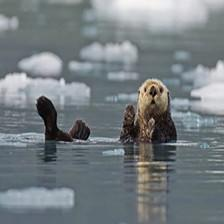

In [5]:
from PIL import Image
import os, os.path
path = '/content/drive/MyDrive/CS_523/Project/enhydra-lutris_24_0f938685.jpg'
img = cv2.imread(path)
cv2_imshow(img)

In [6]:
#for i,j in zip([1,3,5,7],[7,3,5,1]):
def randomized_gaussianBlur(img):
    
    random.seed(datetime.now())
    x = random.randint(2, 6)
    y = random.randint(2, 6)
    if y%2==0: y -=1
    if x%2==0: x -=1
    sigmaX = random.uniform(0.1,2)
    sigmaY = random.uniform(0.1,2)
    blur = cv2.GaussianBlur(img,(x,y),sigmaX,sigmaY)
    return blur

def add_randomized_noise(image):
    random.seed(datetime.now())
    x = random.randint(0, 1)
    if x == 0 or x==1:
        row,col,ch = image.shape
        var = random.uniform(1, 2)
        gauss_color = np.random.normal(0,var**0.5,(row,col,ch))
        gauss_gray = np.random.normal(0,var**0.5,(row,col,1))
        if x==1: gauss = gauss_color.reshape(row,col,ch)
        else: gauss = gauss_gray.reshape(row,col,1)
        return image + gauss
    else:
       #poisson doesn't work for new
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy

def resize(img,order,original_h,original_w):
    row,col,ch = img.shape
    random.seed(datetime.now())
    ran = random.randint(1, 3)
    method = None
    if ran==1:
        method = cv2.INTER_CUBIC
    elif ran==2:
        method = cv2.INTER_LINEAR
    else:
        method = cv2.INTER_AREA
    if order==1:
        smaller_size=random.randint((row/2)+1, row-1)
        down_size = (smaller_size, smaller_size) 
        resized_down = cv2.resize(img, down_size, interpolation= method)
    if order==2:
        resized_down = cv2.resize(img, (original_h//2,original_w//2), interpolation= method)

    return resized_down

def jpeg_compression(img):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
    result, encimg = cv2.imencode('.jpg', img, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg
#pil_image.save(path_0[0:-4]+"_compressed.jpg",optimize=True,quality=30) 

def get_filter():
    fc = 0.2  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
    b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)
    h = np.sinc(2 * fc * (n - (N - 1) / 2))
 
    w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + \
        0.08 * np.cos(4 * np.pi * n / (N - 1))

    h = h * w
    h = h / np.sum(h)
    filter = np.outer(h, h)
    return filter

def sinc_filter(img):
    filter = get_filter()
    h,w,c = img.shape
    res = np.zeros((h,w,0))
    #print(img[:,:,1])
    for i in range(3):
        tmp = signal.convolve2d(img[:,:,i], filter, boundary='symm', mode='same')
        res = np.append(res,tmp.reshape(h,w,1), axis=2)
    return res

In [7]:
def image_degradation(img):
    h,w,c = img.shape
    print(h,w,c)
    random.seed(datetime.now())
    order1 = [1,2,3,4]
    order2 = [1,2,3,4]
    random.shuffle(order1)
    random.shuffle(order2)
    for i in order1:
        if i==1:
            img = resize(img,1,h,w)
            cv2_imshow(img)
            print("order1 resize")
            print(img.shape)
        elif i==2:
            img = randomized_gaussianBlur(img)
            cv2_imshow(img)
            print("order1 gaussianBlur")
        elif i==3:
            img = add_randomized_noise(img)
            cv2_imshow(img)
            print("order1 random noise")
        else:
            jpeg_compression(img)
            cv2_imshow(img)
            print("order1 jpeg compression")
    for i in order2:
        if i==1:
            img = resize(img,2,h,w)
            cv2_imshow(img)
            print("order2 resize")
            print(img.shape)
        elif i==2:
            img = randomized_gaussianBlur(img)
            cv2_imshow(img)
            print("order2 gaussian blur")
        elif i==3:
            img = add_randomized_noise(img)
            cv2_imshow(img)
            print("order2 random noise")
        else:
            img = jpeg_compression(img)
            img = sinc_filter(img)
            cv2_imshow(img)
            print("order2 jpeg compression+sinc filtering")
    return img

224 224 3


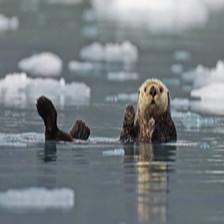

order1 gaussianBlur


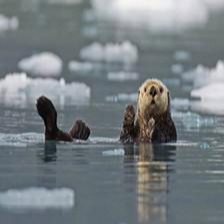

order1 random noise


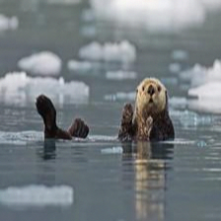

order1 resize
(221, 221, 3)


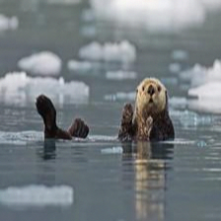

order1 jpeg compression


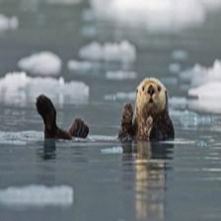

order2 random noise


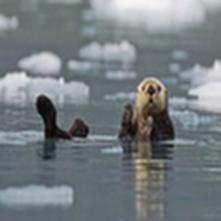

order2 jpeg compression+sinc filtering


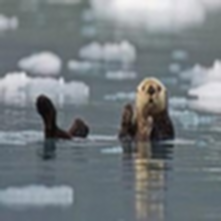

order2 gaussian blur


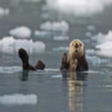

order2 resize
(112, 112, 3)


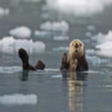

(112, 112, 3)


In [8]:
res = image_degradation(img)
cv2_imshow(res)
print(res.shape)

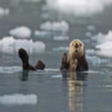

True

In [9]:
cv2_imshow(res)
cv2.imwrite('/content/drive/MyDrive/CS_523/Project/test_degraded.jpg', res)

In [ ]:
bilinear_img = cv2.resize(res,None, fx = img.shape[0], fy = img.shape[1], interpolation = cv2.INTER_NEAREST)
cv2.imshow(bilinear_img)